# OSMnx Features Limeira

In [1]:
import osmnx as ox

In [2]:
import networkx as nx

In [3]:
%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

## Working with street networks

In [4]:
# Geocode a query string to (lat, lng) with the Nominatim geocoder.

my_geocode=ox.geocoder.geocode("Cotil Unicamp, Limeira")
ft_geocode=my_geocode
ft_geocode

(-22.5624156, -47.42519798682734)

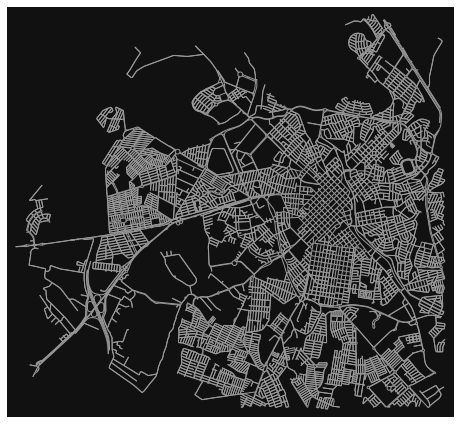

In [5]:
# get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want

networkRange = 5000  # meters
G = ox.graph_from_point(ft_geocode, dist=networkRange, network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0)

In [6]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
#D = ox.utils_graph.get_digraph(G)

In [42]:
import pandas as pd

In [64]:
gdf_edges = pd.read_csv('bigScale_DataSet/gdf_edges_final.csv',index_col=["u","v","key"])
gdf_nodes = pd.read_csv('bigScale_DataSet/gdf_nodes_final.csv',index_col=["node_id"],float_precision='round_trip')

## Routing

# CENTRALITY

### Transform 
##### New Drip
adding gc_distance

In [65]:
def plot_graph_routeNog(
    G,
    route,
    route_color="r",
    route_linewidth=4,
    route_alpha=0.5,
    orig_dest_size=100,
    ax=None,
    **pg_kwargs,
):
    if ax is None:
        # plot the graph but not the route, and override any user show/close
        # args for now: we'll do that later
        override = {"show", "save", "close"}
        kwargs = {k: v for k, v in pg_kwargs.items() if k not in override}
        fig, ax = ox.plot_graph(G, show=False, save=False, close=False, **kwargs)
    else:
        fig = ax.figure

    # scatterplot origin and destination points (first/last nodes in route)
    x = (G.nodes[route[0]]["x"], G.nodes[route[-1]]["x"])
    y = (G.nodes[route[0]]["y"], G.nodes[route[-1]]["y"])
    ax.scatter(x, y, s=orig_dest_size, c=route_color, alpha=route_alpha, edgecolor="none")

    # assemble the route edge geometries' x and y coords then plot the line
    x = []
    y = []
    
    my_i=0
    my_color=['b','g','r','c','m','y','k','w']
    
    
    
    
    for u, v in zip(route[:-1], route[1:]):
        # if there are parallel edges, select the shortest in length
        data = min(G.get_edge_data(u, v).values(), key=lambda d: d["length"])
        
        if "geometry" in data:
            # if geometry attribute exists, add all its coords to list
            xs, ys = data["geometry"].xy
            x.extend(xs)
            y.extend(ys)
            
            ax.plot(xs, ys, c=route_color, lw=route_linewidth, alpha=route_alpha)
        else:
            # otherwise, the edge is a straight line from node to node
            x.extend((G.nodes[u]["x"], G.nodes[v]["x"]))
            y.extend((G.nodes[u]["y"], G.nodes[v]["y"]))
            
        my_i=my_i+1
            
    #ax.plot(x[:int(len(x)/2)], y[:int(len(y)/2)], c='g', lw=route_linewidth, alpha=1)
    #ax.plot(x[int(len(x)/2)-1:], y[int(len(y)/2)-1:], c='r', lw=route_linewidth, alpha=1)

    # save and show the figure as specified, passing relevant kwargs
    sas_kwargs = {"save", "show", "close", "filepath", "file_format", "dpi"}
    kwargs = {k: v for k, v in pg_kwargs.items() if k in sas_kwargs}
    fig, ax = ox.plot._save_and_show(fig, ax, **kwargs)
    return fig, ax

In [66]:
# Geocode a query string to (lat, lng) with the Nominatim geocoder.

rodoviaria_geocode=ox.geocoder.geocode("Barão de Campinas, 50 - Centro, Limeira")


In [67]:
rodoviaria_node = ox.distance.nearest_nodes(G, Y=rodoviaria_geocode[0], X=rodoviaria_geocode[1])
rodoviaria_node

1686083989

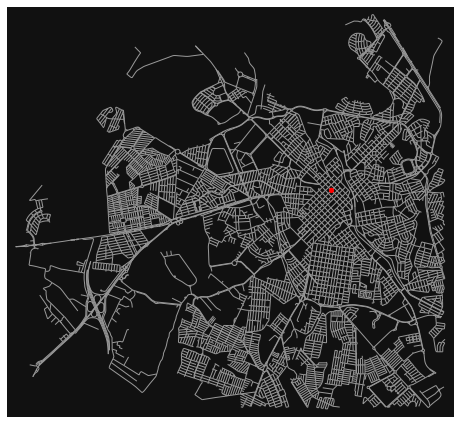

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [68]:
my_route=[rodoviaria_node]
plot_graph_routeNog(M, my_route, node_size=0,edge_linewidth=1,route_linewidth=2,route_alpha=1,orig_dest_size=25)

# newDrip

In [71]:
edges_gcd={}

for index,row in gdf_edges[["from","to"]].iterrows():
    
    from_gcd=gdf_nodes.loc[row["from"],("gc_distance")]
    to_gcd=gdf_nodes.loc[row["to"],("gc_distance")]
   
    edges_gcd[index]=(-1)*((from_gcd+to_gcd)/2)
    

In [72]:
print("len(edges_gcd):"+str(len(edges_gcd)))
print("len(gdf_edges):"+str(len(gdf_edges)))
print("len(nx.line_graph(G)):"+str(len(nx.line_graph(M))))

len(edges_gcd):10514
len(gdf_edges):10514
len(nx.line_graph(G)):10514


In [73]:
nx.set_edge_attributes(M, edges_gcd, "edge_gcd")

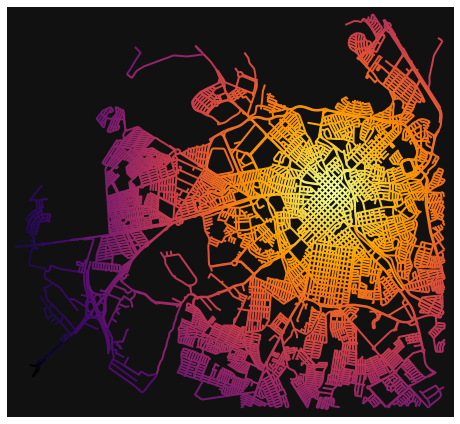

In [74]:
# color edges in original graph with Great-Circle Distance from line graph
ec = ox.plot.get_edge_colors_by_attr(M, "edge_gcd", cmap="inferno")
fig, ax = ox.plot_graph(M, edge_color=ec, edge_linewidth=2, node_size=0)

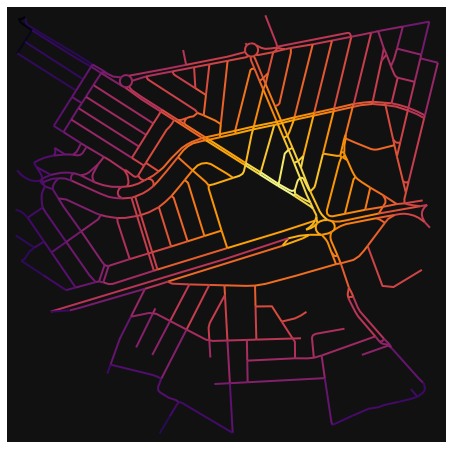

In [87]:
#fig, ax = ox.plot_graph(M, edge_color=ec, edge_linewidth=2, node_size=0,save=True, show=True,filepath ="heuristic_notAdmissible.png")

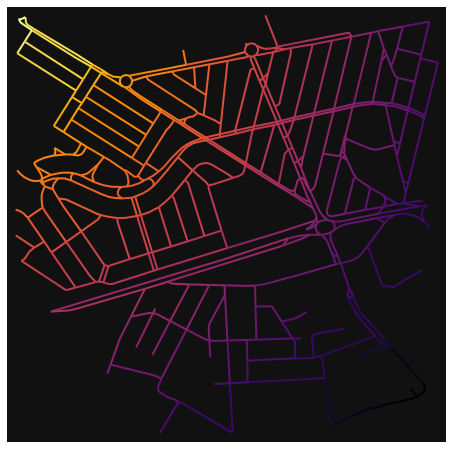

In [92]:
#Save Plot
fig, ax = ox.plot_graph(M, edge_color=ec, edge_linewidth=2, node_size=0,save=True, show=True,filepath ="heuristic_notAdmissible.png")

# Tree
Lista fechada e lista aberta

In [10]:
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

##### from A*

In [55]:
aStar_tree={1449572534: {'pai': -1, 'state': 'closed'},
 2479553906: {'pai': 1449572534, 'state': 'closed'},
 2479553541: {'pai': 1449572534, 'state': 'opened'},
 2479553554: {'pai': 1449572534, 'state': 'closed'},
 1449666303: {'pai': 2479553906, 'state': 'closed'},
 2479554102: {'pai': 2479553906, 'state': 'opened'},
 1449666297: {'pai': 1449666303, 'state': 'closed'},
 8411488059: {'pai': 1449666303, 'state': 'closed'},
 2479553421: {'pai': 2479553554, 'state': 'opened'},
 2479553525: {'pai': 2479553554, 'state': 'opened'},
 2479553621: {'pai': 2479553554, 'state': 'closed'},
 2479553306: {'pai': 2479553621, 'state': 'opened'},
 2479553731: {'pai': 2479553621, 'state': 'closed'},
 1449666300: {'pai': 8411488059, 'state': 'closed'},
 2479553970: {'pai': 8411488059, 'state': 'closed'},
 1449666308: {'pai': 2479553970, 'state': 'opened'},
 2479554204: {'pai': 2479553970, 'state': 'opened'},
 8410675646: {'pai': 1449666297, 'state': 'opened'},
 2479553175: {'pai': 1449666297, 'state': 'opened'},
 2479552955: {'pai': 1449666297, 'state': 'opened'},
 2479553006: {'pai': 2479553731, 'state': 'opened'},
 2479553159: {'pai': 2479553731, 'state': 'opened'},
 1449666299: {'pai': 1449666300, 'state': 'opened'},
 1449666305: {'pai': 1449666300, 'state': 'closed'},
 2479553519: {'pai': 1449666305, 'state': 'opened'},
 8407687623: {'pai': 1449666305, 'state': 'closed'},
 2479553281: {'pai': 8407687623, 'state': 'closed'},
 2479553394: {'pai': 8407687623, 'state': 'opened'}}

In [56]:
len(aStar_tree)

28

In [70]:
graph_edges=[]
open_edges=[]

for i in aStar_tree:
    pai=aStar_tree[i]["pai"]
    
    graph_edges.append([i,pai])
    
    if aStar_tree[i]["state"]=="opened":
        open_edges.append([pai, i])

    print(aStar_tree[i])

{'pai': -1, 'state': 'closed'}
{'pai': 1449572534, 'state': 'closed'}
{'pai': 1449572534, 'state': 'opened'}
{'pai': 1449572534, 'state': 'closed'}
{'pai': 2479553906, 'state': 'closed'}
{'pai': 2479553906, 'state': 'opened'}
{'pai': 1449666303, 'state': 'closed'}
{'pai': 1449666303, 'state': 'closed'}
{'pai': 2479553554, 'state': 'opened'}
{'pai': 2479553554, 'state': 'opened'}
{'pai': 2479553554, 'state': 'closed'}
{'pai': 2479553621, 'state': 'opened'}
{'pai': 2479553621, 'state': 'closed'}
{'pai': 8411488059, 'state': 'closed'}
{'pai': 8411488059, 'state': 'closed'}
{'pai': 2479553970, 'state': 'opened'}
{'pai': 2479553970, 'state': 'opened'}
{'pai': 1449666297, 'state': 'opened'}
{'pai': 1449666297, 'state': 'opened'}
{'pai': 1449666297, 'state': 'opened'}
{'pai': 2479553731, 'state': 'opened'}
{'pai': 2479553731, 'state': 'opened'}
{'pai': 1449666300, 'state': 'opened'}
{'pai': 1449666300, 'state': 'closed'}
{'pai': 1449666305, 'state': 'opened'}
{'pai': 1449666305, 'state': 'clo

In [76]:
open_edges

[[1449572534, 2479553541],
 [2479553906, 2479554102],
 [2479553554, 2479553421],
 [2479553554, 2479553525],
 [2479553621, 2479553306],
 [2479553970, 1449666308],
 [2479553970, 2479554204],
 [1449666297, 8410675646],
 [1449666297, 2479553175],
 [1449666297, 2479552955],
 [2479553731, 2479553006],
 [2479553731, 2479553159],
 [1449666300, 1449666299],
 [1449666305, 2479553519],
 [8407687623, 2479553394]]

In [75]:
i=4
for e in open_edges:
    print("route"+str(i)+"="+str(e))
    i=i+1

route4=[1449572534, 2479553541]
route5=[2479553906, 2479554102]
route6=[2479553554, 2479553421]
route7=[2479553554, 2479553525]
route8=[2479553621, 2479553306]
route9=[2479553970, 1449666308]
route10=[2479553970, 2479554204]
route11=[1449666297, 8410675646]
route12=[1449666297, 2479553175]
route13=[1449666297, 2479552955]
route14=[2479553731, 2479553006]
route15=[2479553731, 2479553159]
route16=[1449666300, 1449666299]
route17=[1449666305, 2479553519]
route18=[8407687623, 2479553394]


In [58]:
len(graph_edges)

28

In [59]:
graph_edges

[[1449572534, -1],
 [2479553906, 1449572534],
 [2479553541, 1449572534],
 [2479553554, 1449572534],
 [1449666303, 2479553906],
 [2479554102, 2479553906],
 [1449666297, 1449666303],
 [8411488059, 1449666303],
 [2479553421, 2479553554],
 [2479553525, 2479553554],
 [2479553621, 2479553554],
 [2479553306, 2479553621],
 [2479553731, 2479553621],
 [1449666300, 8411488059],
 [2479553970, 8411488059],
 [1449666308, 2479553970],
 [2479554204, 2479553970],
 [8410675646, 1449666297],
 [2479553175, 1449666297],
 [2479552955, 1449666297],
 [2479553006, 2479553731],
 [2479553159, 2479553731],
 [1449666299, 1449666300],
 [1449666305, 1449666300],
 [2479553519, 1449666305],
 [8407687623, 1449666305],
 [2479553281, 8407687623],
 [2479553394, 8407687623]]

In [60]:
G=nx.Graph()
G.add_edges_from(graph_edges)

color_map=[]

for node in G:
    state="closed"
    
    if node!=-1:
        state=aStar_tree[node]["state"]
        
    if state=="closed":
        color_map.append("red")
    else:
        color_map.append("#FFE533")
        
    print(node)

1449572534
-1
2479553906
2479553541
2479553554
1449666303
2479554102
1449666297
8411488059
2479553421
2479553525
2479553621
2479553306
2479553731
1449666300
2479553970
1449666308
2479554204
8410675646
2479553175
2479552955
2479553006
2479553159
1449666299
1449666305
2479553519
8407687623
2479553281
2479553394


In [61]:
len(G)

29

In [62]:
len(color_map)

29

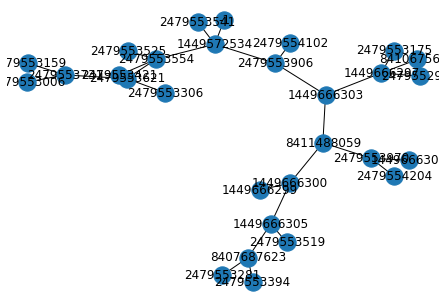

In [63]:
nx.draw(G,  with_labels=True)

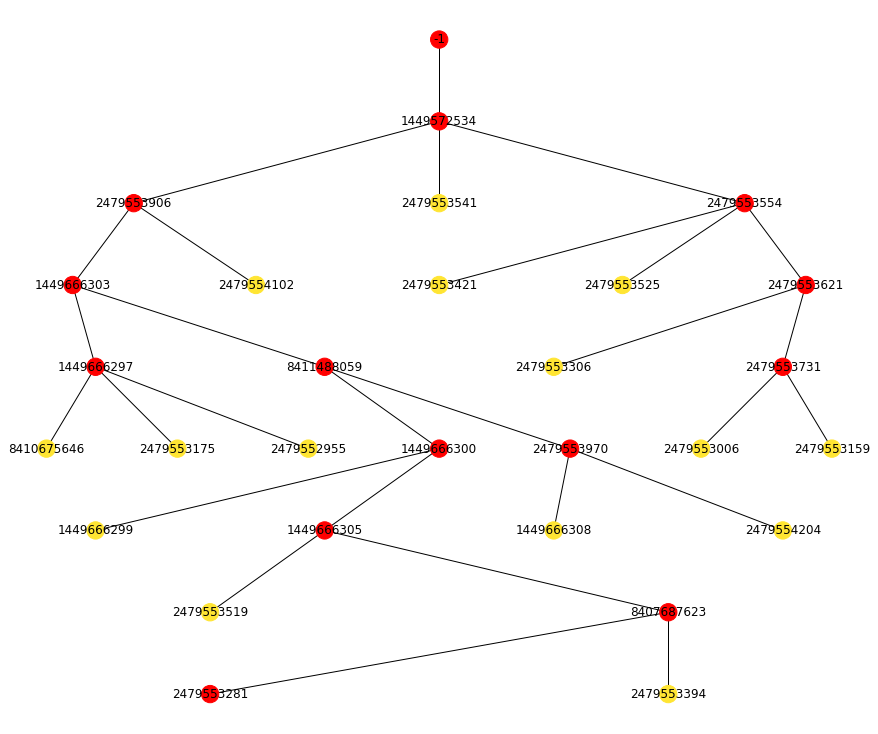

In [64]:

G=nx.Graph()
G.add_edges_from(graph_edges)
pos = hierarchy_pos(G,-1) 

f=plt.figure(figsize=(12,10)) 
nx.draw(G, pos=pos, with_labels=True,node_color=color_map)
#f.savefig("graph.png")
#plt.savefig('hierarchy.png')

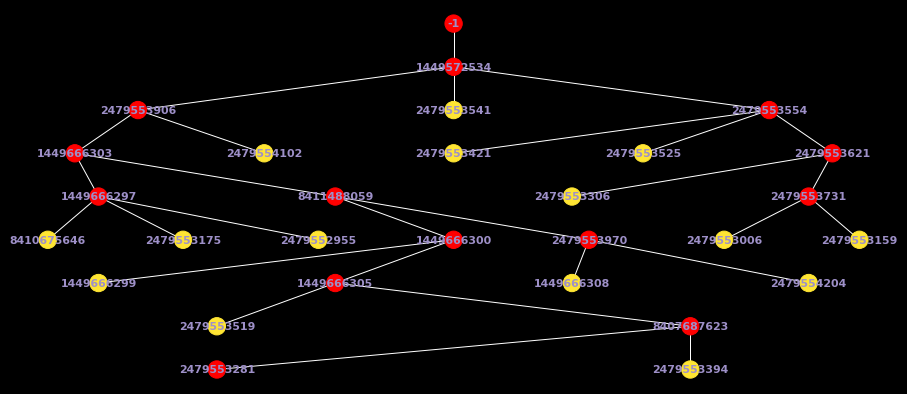

In [67]:
G=nx.Graph()
G.add_edges_from(graph_edges)
pos = hierarchy_pos(G,-1) 

fig, ax = plt.subplots()

nx.draw(G, pos=pos, node_color=color_map, with_labels=True,
        edge_color=["white"],font_color="#9e90c8",font_size=11,font_weight="bold")

ax.set_facecolor('black')
ax.axis('off')
fig.set_facecolor('black')
plt.gcf().set_size_inches(16, 7)

plt.show()
fig.savefig("graph.png")